## Globant - Data Science Challenge

### By: Adrian Zuur

I am going to take a look at the first problem. The problem statement is below.


*###1. NSF Research Awards Abstracts*

*This dataset comprises several paper abstracts, one per file, that were furnished by the NSF
(National Science Foundation). A sample abstract is shown at the end.*

*Your task is developing an unsupervised model which classifies abstracts into a topic (discover
them!). Indeed, your goal is to group abstracts based on their semantic similarity.
You can get a sample of abstracts [here](https://www.nsf.gov/awardsearch/download?DownloadFileName=2020&All=true). Be creative and state clearly your approach. Although
we don’t expect accurate results but a good pipeline of your work.
It is affordable to create a notebook, like Jupyter (if you use python) or a Rmarkdown
report (in case you use R) and make it available for us, i.e. github.
Hint to success in your quest: Develop and stay clear of the data science process you'll
perform over the dataset and highlight important aspects you might consider affordable
to discuss over.*

*Aside notes: All fields in every abstract file wouldn’t be needed. Be keen.*
*Good luck and have fun.*

### 0. Preliminaries

For reproducibility, I am using [Jupyter's official data science Docker image](https://hub.docker.com/r/jupyter/datascience-notebook/) as a base stack. I added extra dependencies in a requirements.txt file. These things don't solve all all reproducibility concerns, but are a good start. See the current directory for details.



In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')


from typing import List, Callable
from functools import reduce
from bs4 import BeautifulSoup
from html import unescape
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Game plan

I am planning to do clustering (non-supervised learning) to discover meaningful groups of the 2020 NSF grants. In essence, this is a problem of dimensionality reduction: how can I summarize the relatively complex text data that describes NSF grants into a few features (or only one!) that capture their main topics?

### 2. EDA - What does the data look like?

To begin, I like to take a look at a few data points from the beginning, middle, and end of the dataset. I downloaded the data into the data/ directory. Here are some sample points below

In [2]:
with open('data/2000005.xml', 'r') as f:
    sample_1 = f.read()
sample_1_bs = BeautifulSoup(sample_1, "xml")
print(sample_1_bs.prettify())

<?xml version="1.0" encoding="utf-8"?>
<rootTag>
 <Award>
  <AwardTitle>
   Collaborative Research: Excellence in Research: Impact of Gbx2 on neural crest cells during neuronal, craniofacial and cardiovascular development
  </AwardTitle>
  <AGENCY>
   NSF
  </AGENCY>
  <AwardEffectiveDate>
   07/01/2020
  </AwardEffectiveDate>
  <AwardExpirationDate>
   06/30/2023
  </AwardExpirationDate>
  <AwardTotalIntnAmount>
   229338.00
  </AwardTotalIntnAmount>
  <AwardAmount>
   229338
  </AwardAmount>
  <AwardInstrument>
   <Value>
    Standard Grant
   </Value>
  </AwardInstrument>
  <Organization>
   <Code>
    08090100
   </Code>
   <Directorate>
    <Abbreviation>
     BIO
    </Abbreviation>
    <LongName>
     Direct For Biological Sciences
    </LongName>
   </Directorate>
   <Division>
    <Abbreviation>
     IOS
    </Abbreviation>
    <LongName>
     Division Of Integrative Organismal Systems
    </LongName>
   </Division>
  </Organization>
  <ProgramOfficer>
   <SignBlockName>
    S

In [3]:
with open('data/2055773.xml', 'r') as f:
    sample_2 = f.read()
sample_2_bs = BeautifulSoup(sample_2, "xml")
print(sample_2_bs.prettify())

<?xml version="1.0" encoding="utf-8"?>
<rootTag>
 <Award>
  <AwardTitle>
   Collaborative Research: SaTC: CORE: Medium: Narrowing The Gap Between Privacy Expectations and Reality in Mobile Health
  </AwardTitle>
  <AGENCY>
   NSF
  </AGENCY>
  <AwardEffectiveDate>
   03/01/2021
  </AwardEffectiveDate>
  <AwardExpirationDate>
   02/29/2024
  </AwardExpirationDate>
  <AwardTotalIntnAmount>
   196533.00
  </AwardTotalIntnAmount>
  <AwardAmount>
   196533
  </AwardAmount>
  <AwardInstrument>
   <Value>
    Standard Grant
   </Value>
  </AwardInstrument>
  <Organization>
   <Code>
    05050000
   </Code>
   <Directorate>
    <Abbreviation>
     CSE
    </Abbreviation>
    <LongName>
     Direct For Computer &amp; Info Scie &amp; Enginr
    </LongName>
   </Directorate>
   <Division>
    <Abbreviation>
     CNS
    </Abbreviation>
    <LongName>
     Division Of Computer and Network Systems
    </LongName>
   </Division>
  </Organization>
  <ProgramOfficer>
   <SignBlockName>
    Sara Kiesle

In [4]:
with open('data/2020751.xml', 'r') as f:
    sample_3 = f.read()
sample_3_bs = BeautifulSoup(sample_3, "xml")
print(sample_3_bs.prettify())

<?xml version="1.0" encoding="utf-8"?>
<rootTag>
 <Award>
  <AwardTitle>
   GCR: Collaborative Research: Jumpstarting Successful Open-Source Software Projects With Evidence-Based Rules and Structures
  </AwardTitle>
  <AGENCY>
   NSF
  </AGENCY>
  <AwardEffectiveDate>
   10/01/2020
  </AwardEffectiveDate>
  <AwardExpirationDate>
   09/30/2025
  </AwardExpirationDate>
  <AwardTotalIntnAmount>
   2082563.00
  </AwardTotalIntnAmount>
  <AwardAmount>
   671539
  </AwardAmount>
  <AwardInstrument>
   <Value>
    Continuing Grant
   </Value>
  </AwardInstrument>
  <Organization>
   <Code>
    01060400
   </Code>
   <Directorate>
    <Abbreviation>
     O/D
    </Abbreviation>
    <LongName>
     Office Of The Director
    </LongName>
   </Directorate>
   <Division>
    <Abbreviation>
     OIA
    </Abbreviation>
    <LongName>
     Office of Integrative Activities
    </LongName>
   </Division>
  </Organization>
  <ProgramOfficer>
   <SignBlockName>
    Dragana Brzakovic
   </SignBlockName>


What do I see?

The data is in XML files. The whole object comprises a lot of information related to the grants awarded, but most doesn't seem very helpful. Some fields that caught my eye:


- **Award -> AwardTitle**: The title of the grant. In theory this should be useful as a concise listing of the topics of the grant.
- **Organization -> Directorate -> Name**: Name of department at university. Maybe somewhat useful? Not always available.
- **Organization -> Division -> Name**: Name of (sub?)department at university. Maybe somewhat useful?
- **AbstractNarration**: The meat of the information. This should be sufficient to extract clusters. In fact, could it be too much (curse of dimensionality)?.
- **Performance_Institution -> Name** Name of university/department?
- **ProgramReference -> Text**: My guess: the NSF program that funds the grant. Some data points have several of these, apparently. One mentions HBCUs... interesting.



For good measure, I downloaded the schema of the XML files from the NSF's website to get a clearer view of the structure of the object. It's printed below. If I had more time, I'd like to get a data dictionary, which could explain the meaning of these fields in more detail.

In [5]:
with open('award_schema.xsd', 'r') as f:
    data_schema = f.read()
data_schema_bs = BeautifulSoup(data_schema, "xml")
print(data_schema_bs.prettify())

<?xml version="1.0" encoding="utf-8"?>
<xsd:schema attributeFormDefault="unqualified" elementFormDefault="qualified" version="1.0" xmlns:xsd="http://www.w3.org/2001/XMLSchema">
 <xsd:element name="rootTag">
  <xsd:complexType>
   <xsd:sequence>
    <xsd:element name="Award">
     <xsd:complexType>
      <xsd:sequence>
       <xsd:element name="AwardTitle" type="xsd:string"/>
       <xsd:element name="AwardEffectiveDate" type="xsd:dateTime"/>
       <xsd:element name="AwardExpirationDate" type="xsd:dateTime"/>
       <xsd:element name="AwardAmount" type="xsd:int"/>
       <xsd:element name="AwardInstrument">
        <xsd:complexType>
         <xsd:sequence>
          <xsd:element name="Value" type="xsd:string"/>
         </xsd:sequence>
        </xsd:complexType>
       </xsd:element>
       <xsd:element name="Organization">
        <xsd:complexType>
         <xsd:sequence>
          <xsd:element name="Code" type="xsd:int"/>
          <xsd:element name="Directorate">
           <xsd:com

### 3. Thoughts on data processing and modeling

My instinct is to try clustering on abstracts, titles, and "ProgramReferences". An idea is to try these separately, and see if they coincide; if they do, that would be a signal of robust results.

To model texts I think it is good enough to encode them as bags-of-words, maybe including up to bigrams, maybe using tf-idf scores. Text topics are usually identified by a few keywords. I don't think grammar (order of words) is so important for this kind of thing. 

It might be nice to use some kind of "sentence2vec" encoding, which could give a clearer semantic representation of the text, but I thought about this too late, and I think it's overkill for a first approximation. Also, maybe pre-trained "2vec" models online might not be fine-tuned to the meanings in this corpora.

On the cleaning of the text data, I saw some html, which needs to be removed. I think it's also OK if we remove everything that is not a letter (numbers, punctuation, etc). Also, I won't worry about misspelled words: these are academic texts, right?

It might be nice to use stemming and lemmatization, but I thought about it too late, and I don't think it's necessary for now.

Since I don't have so much time, I will only do kmeans clustering. I also tried hierarchical clustering, but it is more computationally expensive and not worth the wait for now.

### 4. Loading and processing data

Below are some functions to load and process text data from XMLs. I wrote them thinking about the possibility of having several matches for tag in each XML object (for example, in our case, there may be several ProgramReferences per XML).

In [6]:
def lmap(func, itr):
    """List after map"""
    return list(map(func, itr))

def load_xml_from_path(path: str) -> BeautifulSoup:
    """Loads an XML file from a path, outputs a BeautifulSoup object"""
    with open(path, 'r') as f:
        dump = f.read()
    return BeautifulSoup(dump, "xml")

def get_fields_from_bs(bs_objects: List[BeautifulSoup],
                       keys: List[str]) -> List[BeautifulSoup]:
    """Recursively queries a list of BeautifulSoup (XML) objects using a list of keys
    and retrieves whatever text is found at the deepest nodes queried in a nested list."""
    if len(keys) == 0:
        return lmap(BeautifulSoup.get_text, bs_objects)[0]
    
    else:
        key = keys[0]
        matches = map(
            lambda x: BeautifulSoup.find_all(x, key),
            bs_objects)
        return [get_fields_from_bs(l, keys[1:]) for l in matches]

def flatten(iterable):
    """Memory-efficient recursive flattening of lists. Taken from 
    http://rightfootin.blogspot.com/2006/09/more-on-python-flatten.html"""
    it = iter(iterable)
    for e in it:
        if isinstance(e, (list, tuple)):
            for f in flatten(e):
                yield f
        else:
            yield e

def flatten_except_top_level(nested_lists: List) -> List[List]:
    """Flattens a list of lists, except for the top level. Returns a list of lists, but those lists 
    are not themselves lists of lists (think about that for a second). In this case, useful to flatten
    data within XMLs, but not between them."""
    return map(
        lambda x: list(flatten(x)) if isinstance(x, list) else [x], 
        nested_lists)

def process_nested_fields(nested: List[List],
                          process: Callable,
                          join: Callable) -> List[str]: 
    """Gets a single data point from a structure of nested lists. 
    Each top-level list is flattened, its elements are processed using the process parameter, and
    then joined using the join parameter."""
    flattened = flatten_except_top_level(nested)
    processed = map(lambda x: map(process, x), flattened) 
    joined = map(join, processed)
    return joined

def process_text(text: str) -> str:
    """My text preprocessing function. Gets rid of html, stopwords, and everything that isn't a
    letter. Doesn't do lemmatization or stemming."""
    text_1 = unescape(text.lower())
    text_2 = re.compile(r'<[^>]+>').sub('', text_1)
    text_3 = re.compile(r"[^a-z ]+").sub(' ', text_2)
    text_4 = re.compile(r"\s{2,}").sub('', text_3)
    text_5 = word_tokenize(text_4)
    text_6 = [w for w in text_5 if not w.lower() in STOP_WORDS]
    text_7 = " ".join(text_6)
    return text_7

def join_text(list_of_texts: List[str]) -> str:
    """Basic text join with spaces"""
    joined = " ".join(list_of_texts)
    return joined


#Some examples.

#x = get_fields_from_bs(sample_1_bs, ['ProgramReference', 'Text'])
#x = get_fields_from_bs([sample_1_bs, sample_2_bs, sample_3_bs], ['Award', 'AwardTitle'])
#x = get_fields_from_bs([sample_1_bs, sample_2_bs, sample_3_bs], ['AbstractNarration'])

#y = flatten_except_first_level(x)
#z = map(lambda x: map(process, x), y) 
#w = map(lambda x: " ".join(x), y)

#w = process_nested_fields(x, process_text, join_text)


We can now create our corpora of clean texts.

In [7]:
filepaths = [os.path.join("data", x) for x in os.listdir("data")]
data = lmap(load_xml_from_path, filepaths)

In [8]:
titles = get_fields_from_bs(data, ['Award', 'AwardTitle'])
title_corpus = process_nested_fields(titles, process_text, join_text)

abstracts = get_fields_from_bs(data, ['AbstractNarration'])
abstract_corpus = process_nested_fields(abstracts, process_text, join_text)

programs = get_fields_from_bs(data, ['ProgramReference', 'Text'])
program_corpus = process_nested_fields(programs, process_text, join_text)


### 5. Text embeddings

I am going to represent the texts in Euclidean spaces using tf-idf scores. I am also going use strict term frequency cutoffs for abstracts (words in more than 50% of documents are excluded). My rationale for both choices is that I don't want to focus on the noise from frequent uninformative words. Tf-idf makes document word-scores more comparable among themselves, limiting inflation due to their overall frequency in the corpus, and thus helps algorithms based on Euclidean distance (like basic k-means) not get fooled by that. As for the cutoff, it helps by removing presumably uninformative dimensions from the dataset.

In [9]:
title_vectorizer = TfidfVectorizer(min_df = 0.01, max_df = 0.99, ngram_range = (1,2))
title_vectors = title_vectorizer.fit_transform(title_corpus)
title_terms = title_vectorizer.get_feature_names()

abstract_vectorizer = TfidfVectorizer(min_df = 0.02, max_df = 0.5, ngram_range = (1,2))
abstract_vectors = abstract_vectorizer.fit_transform(abstract_corpus)
abstract_terms = abstract_vectorizer.get_feature_names()

program_vectorizer = TfidfVectorizer(min_df = 0.01, max_df = 0.99, ngram_range = (1,2))
program_vectors = program_vectorizer.fit_transform(program_corpus)
program_terms = program_vectorizer.get_feature_names()

In [10]:
print(title_vectors.shape)
print(abstract_vectors.shape)
print(program_vectors.shape)

(12776, 86)
(12776, 1608)
(12776, 172)


Note: the vocabulary size of titles and programs is very sensitive to small changes in the document frequency cutoffs.

In [11]:
print(title_terms)
print(abstract_terms[:10])
print(program_terms)

['across', 'analysis', 'applications', 'approach', 'based', 'biology', 'change', 'climate', 'collaborative', 'communities', 'community', 'computational', 'computing', 'control', 'covid', 'data', 'deep', 'design', 'development', 'dissertation', 'doctoral', 'doctoral dissertation', 'driven', 'dynamics', 'education', 'effects', 'energy', 'engineering', 'environmental', 'evolution', 'fellowship', 'framework', 'high', 'human', 'impact', 'interactions', 'learning', 'low', 'machine', 'machine learning', 'manufacturing', 'materials', 'mechanisms', 'methods', 'model', 'modeling', 'models', 'mriacquisition', 'multi', 'network', 'networks', 'new', 'novel', 'nsf', 'phase', 'physics', 'platform', 'postdoctoral', 'processes', 'quantum', 'rapid', 'research', 'response', 'reu', 'role', 'sbir', 'sbir phase', 'scale', 'science', 'social', 'stem', 'structure', 'student', 'students', 'support', 'system', 'systems', 'technology', 'theory', 'time', 'undergraduate', 'understanding', 'university', 'using', 'v

### 6. Clusters

I fit k-means clustering on my text embeddings. I didn't choose $k$ with the well-known shoulder method (flattening of residual sum of squares curve) because I didn't see clear shoulders in the experiments that I ran. Below I only show a few clusters that illustrate results.

I wanted to do hierarchical clustering, but it's slow and the plots were ugly.

Another kind of clustering algorithms I like are netwrok propagation clustering algorithms. Maybe later.

I also experimented with doing PCA first, in order to reduce the dimension of the dataset before the clustering, but I found it didn't help much.

In [12]:
title_kmeans = KMeans(n_clusters = 10, random_state = 1204).fit(title_vectors)
abstract_kmeans = KMeans(n_clusters = 14, random_state = 1204).fit(abstract_vectors)
program_kmeans = KMeans(n_clusters = 10, random_state = 1204).fit(program_vectors)

In [13]:
def print_text_kmeans_summary(kmeans, vocabulary, n_terms):
    """Prints a summary of kmeans clusters"""
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 
    _, cluster_counts = np.unique(kmeans.labels_, return_counts=True)

    for i in range(kmeans.n_clusters):

        print(f'No. of grants in cluster {i}: {cluster_counts[i]}')
        print(f"Cluster {i} words: ", end='')
        for ind in order_centroids[i, :n_terms]: 
            print(vocabulary[ind], end=', ')
        print() 
        print() 

In [14]:
print("##########\nTitle kmeans:\n##########")
print_text_kmeans_summary(title_kmeans, title_terms, 5)

##########
Title kmeans:
##########
No. of grants in cluster 0: 317
Cluster 0 words: system, computing, collaborative, mriacquisition, high, 

No. of grants in cluster 1: 8479
Cluster 1 words: collaborative, data, using, nsf, science, 

No. of grants in cluster 2: 900
Cluster 2 words: collaborative, water, framework, dynamics, education, 

No. of grants in cluster 3: 237
Cluster 3 words: doctoral, dissertation, doctoral dissertation, social, research, 

No. of grants in cluster 4: 593
Cluster 4 words: research, fellowship, collaborative, education, mriacquisition, 

No. of grants in cluster 5: 278
Cluster 5 words: engineering, research, undergraduate, collaborative, science, 

No. of grants in cluster 6: 403
Cluster 6 words: based, collaborative, research, undergraduate, learning, 

No. of grants in cluster 7: 609
Cluster 7 words: phase, sbir phase, sbir, platform, system, 

No. of grants in cluster 8: 403
Cluster 8 words: systems, collaborative, dynamics, quantum, control, 

No. of gr

In [15]:
print("##########\nAbstract kmeans:\n##########")
print_text_kmeans_summary(abstract_kmeans, abstract_terms, 15)

##########
Abstract kmeans:
##########
No. of grants in cluster 0: 275
Cluster 0 words: quantum, materials, classical, information, pi, physics, computing, systems, magnetic, matter, properties, theory, many, states, theoretical, 

No. of grants in cluster 1: 901
Cluster 1 words: species, plant, evolutionary, microbial, environmental, ecological, genetic, plants, host, across, data, diversity, evolution, changes, natural, 

No. of grants in cluster 2: 1877
Cluster 2 words: study, theory, pi, physics, mathematical, models, wave, understanding, fluid, high, students, problems, geometric, work, flow, 

No. of grants in cluster 3: 479
Cluster 3 words: stem, education, students, learning, financial, income, academic, need, student, supports, pursuing, graduate, teachers, stem education, demonstrated, 

No. of grants in cluster 4: 532
Cluster 4 words: small business, business, business innovation, researchsbirphase, innovation researchsbirphase, innovation, small, researchsbirphase project, 

In [16]:
print("##########\nProgram kmeans:\n##########")
print_text_kmeans_summary(program_kmeans, program_terms, 10)

##########
Program kmeans:
##########
No. of grants in cluster 0: 247
Cluster 0 words: nanoscale bio, core, bio core, nanoscale, bio, covidresearch, graduate involvement, graduate, involvement, rapid, 

No. of grants in cluster 1: 7369
Cluster 1 words: research, project, eager, small, small project, science, systems, workshops, conference workshops, conference, 

No. of grants in cluster 2: 309
Cluster 2 words: stem ed, iuse, improv undergrad, improv, undergrad stem, ed iuse, ed, stem, undergrad, iuse undergraduate, 

No. of grants in cluster 3: 1185
Cluster 3 words: stim, exp prog, comp res, prog stim, prog, stim comp, comp, exp, res, research, 

No. of grants in cluster 4: 654
Cluster 4 words: graduate, graduate involvement, involvement, education graduate, education, anthropology, undergraduate education, undergraduate, sciencemathengtech, sciencemathengtech education, 

No. of grants in cluster 5: 908
Cluster 5 words: career, erly career, faculty erly, career faculty, faculty, care

There are a few takeaways from the above.

- Title and program names are not rich enough to disentangle many clear groups in the data.
- Abstracts show some clear topics around which they group:
    - **Clusters 0 and 2**: Physics and Mathematics
    - **Cluster 1**: Ecology
    - **Cluster 3**: Access to STEM education
    - **Cluster 4**: Small Business Innovation Research
    - **Cluster 5**: Information Systems
    - **Cluster 6**: Scientific collaboration and career development
    - **Cluster 7**: Public Policy
    - **Cluster 8**: Education in STEM
    - **Clusters 9 and 10**: Environmental Science
    - **Cluster 11**: Chemistry and Materials Science
    - **Cluster 12**: Statistics and Machine Learning
    - **Cluster 13**: Cell Biology
- Altogether, the results suggest that grants are not only awarded to projects with scientific goals in specific subject domains, but also to initiaves to support education, outreach, and career development. This can be seen from the variety of Programs associated to the grants, below:

In [17]:
unique_programs, program_counts = np.unique(list(flatten(programs)), return_counts=True)
program_dict = dict(zip(unique_programs, program_counts))
print("##########\nProgramReference counts:\n##########")
for k in program_dict.keys():
    print(f'{k}: {program_dict[k]}')

##########
ProgramReference counts:
##########
(MGI) Materials Genome Initiative: 55
(QL) Quantum Leap: 22
ADVANCE - IT-START: 5
ADVANCE PLAN D: 2
ADVANCE PLAN IHE: 4
ADVANCE-PAID: 13
ADVANCED COMP RESEARCH PROGRAM: 10
ADVANCED LEARNING TECHNOLOGIES: 17
ADVANCED MATERIALS & PROCESSING PROGRAM: 3
ADVANCED SOFTWARE TECH & ALGOR: 55
ADVANCED TECHNOLOGIES & INSTRM: 8
ADVANCED TECHNOLOGY EDUCATION: 139
ADVANCES IN BIO INFORMATICS: 54
AERONOMY: 2
AFRICA, NEAR EAST, & SO ASIA: 7
AGRICULTURAL BIOTECHNOLOGY: 60
AGS: 5
AI Education/Workforce Develop: 35
AI-Supported Learning: 3
ALGORITHMIC FOUNDATIONS: 2
ALGORITHMS: 57
ALGORITHMS IN THREAT DETECTION: 11
AMERICAS PROGRAM: 7
ANIMAL BEHAVIOR: 10
ANIMAL DEVELOPMENTAL MECHANSMS: 8
ANTARCTIC AERONOMY & ASTROPHYS: 3
ANTARCTIC COORDINATION & INFOR: 1
ANTARCTIC INTEGRATED SYS SCI: 5
ANTARCTIC OCEAN & ATMOSPH SCI: 21
ANTARCTIC ORGANISMS & ECOSYST: 8
ARCHAEOLOGY: 89
ARCHAEOMETRY: 4
ARCHIVAL DATA ANALYSIS: 4
ARCTIC RES & POLICY SUPPORT PR: 1
ARCTIC RESEARCH

In [18]:
print("Some examples of Cluster 3 ('Career Development in STEM')")
print(np.where(abstract_kmeans.labels_ == 3)[0][:5])
print()
print(abstracts[63])
print()
print(abstracts[88])
print()
print(abstracts[92])
print()
print(abstracts[129])

Some examples of Cluster 3 ('Career Development in STEM')
[ 63  88  92 129 154]

The Historically Black Colleges and Universities Undergraduate Program (HBCU-UP) has identified research in broadening participation in STEM as one of its priorities and is committed to funding innovative models and research to enhance the understanding of the barriers that hinder and factors that enhance our ability to broaden participation in STEM. The project presented by Howard University, Winston-Salem State University, Coppin State University, and Morehouse College has been designed to initiate the implementation of essential research that will set the foundation for the development of the theoretical models that pertain to the research on identity and motivation of African American students in science, technology, engineering and mathematics fields.  The project consists of the requisite research, education, knowledge transfer and outreach components.  It is uniquely poised to transform current psyc

In [19]:
print("Some examples of Cluster 6 ('Scientific Collaboration')")
print(np.where(abstract_kmeans.labels_ == 6)[0][:5])
print()
print(abstracts[111])
print()
print(abstracts[115])
print()
print(abstracts[171])
print()
print(abstracts[172])

Some examples of Cluster 6 ('Scientific Collaboration')
[111 115 171 172 181]

The evolution of oxygenic photosynthesis changed the trajectory of life on Earth. By about 2.4 billion years ago, photosynthesis began to cause accumulation of oxygen in Earth’s atmosphere. This oxygen eventually allowed multicellular animals to evolve. However, scientists do not know when or how oxygenic photosynthesis evolved. Understanding its origin requires integrating data and ideas from biochemistry, microbiology, evolutionary biology, and Earth history. This project will bring together individual scientists with the breadth of knowledge and diversity of skills to identify and address the key questions for understanding oxygenic photosynthesis. Specifically, researchers will design a cross-disciplinary Biology Integration Institute on The Evolution of Oxygenic Photosynthesis. The team will include university students and early career scientists who will learn cross-disciplinary techniques through part

#### 6.1. Let's plot this thing

I plot the abstracts projecting on to the first two principal components.

In [20]:
abstract_pca = PCA(n_components = 2)
abstract_pca.fit(abstract_vectors.toarray())
abstract_vectors_2 = abstract_pca.transform(abstract_vectors.toarray())

(Code adapted from [Brandon Rose](http://brandonrose.org/clustering))

In [21]:
plot_df = pd.DataFrame(abstract_vectors_2)
plot_df.columns = ["x", "y"]
plot_df["label"] = abstract_kmeans.labels_

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#1b9e77', 3: '#e7298a', 
                  4: '#66a61e', 5: '#a61ea6', 6: '#80ed6f', 7: '#45ad86', 
                  8: '#c3cc14', 9: '#7570b3', 10: '#7570b3', 11: '#6a9e81', 
                  12: '#080807', 13: '#f2ace9'}
cluster_names = {
    0: 'Physics and Mathematics',
    1: 'Ecology',
    2: 'Physics and Mathematics (2)',   
    3: 'Access to STEM education',
    4: 'Small Business Innovation Research',
    5: 'Information Systems',
    6: 'Scientific collaboration and career development',
    7: 'Public Policy',
    8: 'Education in STEM',
    9: 'Environmental Science',
    10: 'Environmental Science (2)',
    11: 'Chemistry and Materials Science',
    12: 'Statistics and Machine Learning',
    13: 'Cell Biology'}

groups = plot_df.groupby('label')


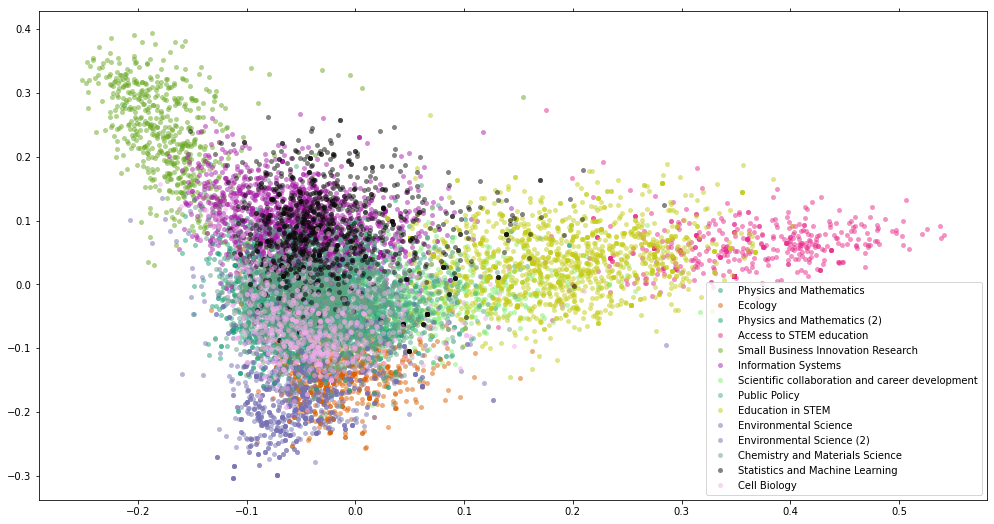

In [22]:
fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none', alpha = 0.5)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',        
        which='both',      
        bottom='off',      
        top='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off')
    
ax.legend(numpoints=1)  
   
    
plt.show() 

Interestingly, the first two principal components seem to capture two obvious but important dimensions of the abstracts. The first one captures to what extent the grant is about "Education in STEM", while the second one captures whether the grant is about small business innovation. These two aspects of grants seem to be *sui generis*, unrelated to the actual subject matter of the research that is central to most grants. In effect, most of the data points seem to be near the origin, suggesting that they are not really about education in STEM nor small business research, but rather about specific scientific problems. These points unfortunately cannot be visualized well here, as they overlap to a great degree. Maybe extra dimensions are needed.

### Epilogue: scraps of code left over

In [23]:
#### TRYING TO RUN HIERARCHICAL CLUSTERS

#from scipy.cluster.hierarchy import ward, dendrogram
#dist = 1 - cosine_similarity(abstract_vectors)
#linkage_matrix = ward(dist) 


#### TRYING USE PCAs

#scaler = MinMaxScaler()
#scaled_abstract_vectors = scaler.fit_transform(abstract_vectors.toarray())
#pca = PCA(n_components = 0.8)
#pca.fit(scaled_abstract_vectors)
#reduced_abstract_vectors = pca.transform(scaled_abstract_vectors)

def calculate_WSS(points, kmax, **kwargs):
    """Function to calculate kmeans within SS score for k values from 1 to kmax.
    Taken from http://brandonrose.org/clustering"""

    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k, **kwargs).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(points.shape[0]):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += np.sum((points[i, :].flatten() - curr_center)**2)
      
        sse.append(curr_sse)
    return sse